# MixedWM38 Preprocessing

This notebook contains the preprocessing steps for the MixedWM38 dataset. We walk through the steps of loading the data, cleaning it, and saving it in a format that is ready for use.

In [1]:
# !pip install --upgrade kaggle pandas

## Imports

In [2]:
import os

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from ssl_wafermap.utilities.transforms import rgb_scale

## Downloading the Data

The dataset is publicly availble at https://www.kaggle.com/datasets/co1d7era/mixedtype-wafer-defect-datasets, and we're after the `Wafer_Map_Dataset.npz` file. All files in the Kaggle dataset can be downloaded using the Kaggle API.

In [3]:
save_path = "../data/raw/MixedWM38/"
dataset = "co1d7era/mixedtype-wafer-defect-datasets"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(dataset, path=save_path, quiet=False, unzip=True)

data = np.load(os.path.join(save_path, "Wafer_Map_Datasets.npz"))
# data.files -> ['arr_0', 'arr_1']
wafer_maps = data["arr_0"]
labels = data["arr_1"]

100%|██████████| 21.8M/21.8M [00:00<00:00, 54.0MB/s]


## Cleaning the Data

Binary wafer maps can only have three distinct pixel values corresponding to passing die, failing die, and non-wafer area. Some of the wafer maps in this dataset have four unique pixel values, and they're all the "Near-Full" type wafer maps. These were created by GANs so it's possible that some poor data was used for training. Moreover, you can easily tell that the incorrect interpolation mode was used to create these synthetic wafer maps, but I digress. 

Here, we show that there are some "bad" wafer maps that have values `{0, 1, 2, 3}` instead of just `{0, 1, 2}`.

Unique pixel values before cleaning: {0, 1, 2, 3}
Number of bad wafers: 105


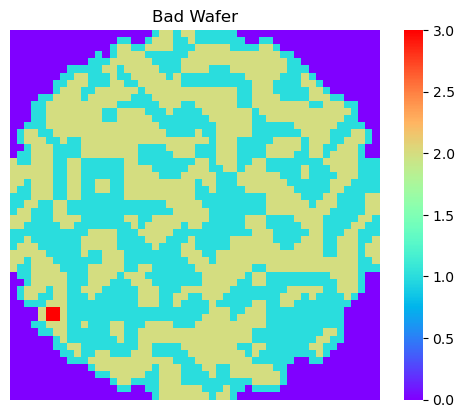

In [4]:
wafers = [wafer for wafer in wafer_maps]
labels = [label for label in labels]

# Show the number of unique pixel values in the uncleaned data
unique_pixels = set()
bad_wafers = []
for wafer in wafers:
    vals = np.unique(wafer).tolist()
    if len(vals) > 3:
        bad_wafers.append(wafer)
    unique_pixels.update(vals)

print(f"Unique pixel values before cleaning: {unique_pixels}")
print(f"Number of bad wafers: {len(bad_wafers)}")

# Show one of the bad wafers in the ugliest color scheme possible
sns.heatmap(bad_wafers[0], cmap="rainbow", square=True)
plt.title("Bad Wafer")
plt.axis("off")
plt.show()

As someone who works in the semiconductor industry, I've never seen a wafer as wonky as these ones. I'm not sure how they were created, but I'm guessing that the interpolation mode was not set to `NEAREST` when creating the synthetic wafer maps. Still, we can use these if we replace all the `3` values with `2`'s in the wafer maps.

In [5]:
for wafer in wafer_maps:
    wafer[wafer == 3] = 2

# Show the number of unique pixel values in the cleaned data
unique_pixels = set()
for wafer in wafers:
    unique_pixels.update(np.unique(wafer).tolist())

print(f"Unique pixel values after cleaning: {unique_pixels}")

Unique pixel values after cleaning: {0, 1, 2}


## Splitting the Data

Now we split the data into training, validation, and test sets. We also save the data in a format that is ready for use.

In [6]:
wafers = [rgb_scale(wafer) for wafer in wafers]
labels = [label.tolist() for label in labels]

df = pd.DataFrame({"waferMap": wafers, "label": labels})
df

,waferMap,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 1, 0, 0, 0, 1, 0]"
...,...,...
38010,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
38011,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
38012,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"
38013,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0]"


In [7]:
# Sanity check to make sure data was cleaned correctly
unique_vals = set()
for wafer in df.waferMap:
    vals = np.unique(wafer).tolist()
    unique_vals.update(vals)

print(f"Unique pixel values: {unique_vals}")

Unique pixel values: {0, 128, 255}


Although this is a multilabel classification problem, there are 38 unique combinations of these labels. To create stratified splits from the full dataset, we can use these label combinations as their own categories. The cell below adds the label combination (failure type) as a new column to the dataframe, and it also creates columns for each of the 9 types of individual defects to show whether or not they are present in the wafer map.

In [8]:
label_mapping ={
    # Single-type defects
    "Normal": [0, 0, 0, 0, 0, 0, 0, 0],
    "C": [1, 0, 0, 0, 0, 0, 0, 0],
    "D": [0, 1, 0, 0, 0, 0, 0, 0],
    "EL": [0, 0, 1, 0, 0, 0, 0, 0],
    "ER": [0, 0, 0, 1, 0, 0, 0, 0],
    "L": [0, 0, 0, 0, 1, 0, 0, 0],
    "NF": [0, 0, 0, 0, 0, 1, 0, 0],
    "S": [0, 0, 0, 0, 0, 0, 1, 0],
    "R": [0, 0, 0, 0, 0, 0, 0, 1],
    # Two-type defects
    "C-EL": [1, 0, 1, 0, 0, 0, 0, 0],
    "C-ER": [1, 0, 0, 1, 0, 0, 0, 0],
    "C-L": [1, 0, 0, 0, 1, 0, 0, 0],
    "C-S": [1, 0, 0, 0, 0, 0, 1, 0],
    "D-EL": [0, 1, 1, 0, 0, 0, 0, 0],
    "D-ER": [0, 1, 0, 1, 0, 0, 0, 0],
    "D-L": [0, 1, 0, 0, 1, 0, 0, 0],
    "D-S": [0, 1, 0, 0, 0, 0, 1, 0],
    "EL-L": [0, 0, 1, 0, 1, 0, 0, 0],
    "EL-S": [0, 0, 1, 0, 0, 0, 1, 0],
    "ER-L": [0, 0, 0, 1, 1, 0, 0, 0],
    "ER-S": [0, 0, 0, 1, 0, 0, 1, 0],
    "L-S": [0, 0, 0, 0, 1, 0, 1, 0],
    # Three-type defects
    "C-EL-L": [1, 0, 1, 0, 1, 0, 0, 0],
    "C-EL-S": [1, 0, 1, 0, 0, 0, 1, 0],
    "C-ER-L": [1, 0, 0, 1, 1, 0, 0, 0],
    "C-ER-S": [1, 0, 0, 1, 0, 0, 1, 0],
    "C-L-S": [1, 0, 0, 0, 1, 0, 1, 0],
    "D-EL-L": [0, 1, 1, 0, 1, 0, 0, 0],
    "D-EL-S": [0, 1, 1, 0, 0, 0, 1, 0],
    "D-ER-L": [0, 1, 0, 1, 1, 0, 0, 0],
    "D-ER-S": [0, 1, 0, 1, 0, 0, 1, 0],
    "D-L-S": [0, 1, 0, 0, 1, 0, 1, 0],
    "EL-L-S": [0, 0, 1, 0, 1, 0, 1, 0],
    "ER-L-S": [0, 0, 0, 1, 1, 0, 1, 0],
    # Four-type defects
    "C-L-EL-S": [1, 0, 1, 0, 1, 0, 1, 0],
    "C-L-ER-S": [1, 0, 0, 1, 1, 0, 1, 0],
    "D-L-EL-S": [0, 1, 1, 0, 1, 0, 1, 0],
    "D-L-ER-S": [0, 1, 0, 1, 1, 0, 1, 0],
}

full_names = {
    "Normal": "Normal",
    "C": "Center",
    "D": "Donut",
    "EL": "Edge-Loc",
    "ER": "Edge-Ring",
    "L": "Loc",
    "NF": "Near-full",
    "S": "Scratch",
    "R": "Random",
}

# Apply the label-mapping to the dataframe, creating a new column
def map_list_to_label(row_list):
    for key, value in label_mapping.items():
        if row_list == value:
            return key

df["failureType"] = df.label.apply(map_list_to_label)

for key, value in label_mapping.items():
    if sum(value) <= 1:
        col = full_names[key]
        # We want to know if this type of failure is present at all in the multi-label
        df[col] = df.failureType.apply(lambda x: True if key in x.split("-") else False)

df.sample(5)

,waferMap,label,failureType,Normal,Center,Donut,Edge-Loc,Edge-Ring,Loc,Near-full,Scratch,Random
13650,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 1, 0, 0, 0, 1, 0]",D-EL-S,False,False,True,True,False,False,False,True,False
26489,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 1, 0, 0, 0, 0]",ER,False,False,False,False,True,False,False,False,False
34528,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0]",Normal,True,False,False,False,False,False,False,False,False
8253,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 1, 1, 0, 0, 0]",C-ER-L,False,True,False,False,True,True,False,False,False
10777,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 1, 0, 0, 0]",C-L,False,True,False,False,False,True,False,False,False


Now we create stratified splits from the full dataset. We use the label combination as the category for stratification. Files are saved as compressed pickle files.

In [9]:
# Make the test set 15% of the data
trainval_data, test_data = train_test_split(
    df, test_size=15 / 100, random_state=42, stratify=df.failureType
)
# From the remaining 85%, make the validation set 15% of the total data
train_data, val_data = train_test_split(
    trainval_data,
    test_size=15 / 85,
    random_state=42,
    stratify=trainval_data.failureType,
)

# Now we create smaller splits for fine-tuning self-supervised models
# We want splits roughly corresponding to 1%, 5%, 10%, and 20% of the training data

# From the training data (~70%), make the 1% split
train_69_split, train_1_split = train_test_split(
    train_data,
    test_size=1 / 70,
    random_state=42,
    stratify=train_data.failureType
)
# Grab a 5% split from the ~69% remaining
train_64_split, train_5_split = train_test_split(
    train_69_split,
    test_size=5 / 69,
    random_state=42,
    stratify=train_69_split.failureType,
)
# Grab a 10% split from the ~64% remaining
train_54_split, train_10_split = train_test_split(
    train_64_split,
    test_size=10 / 64,
    random_state=42,
    stratify=train_64_split.failureType,
)
# Grab a 20% split from the ~54% remaining
train_34_split, train_20_split = train_test_split(
    train_54_split,
    test_size=20 / 54,
    random_state=42,
    stratify=train_54_split.failureType,
)

# Print out the sizes of each split and save them to disk
data_path = "../data/processed/MixedWM38/"
os.makedirs(os.path.join(os.getcwd(), data_path), exist_ok=True)

for split in (
    train_data,
    val_data,
    test_data,
    train_1_split,
    train_5_split,
    train_10_split,
    train_20_split,
):
    split_name = [k for k, v in locals().items() if v is split][0]
    length = len(split)
    fraction = length / len(wafer_maps)
    print(f"{split_name}: {length} samples ({fraction:.1%})")

    # Save the data to a compressed pickle file
    split.to_pickle(
        f"../data/processed/MixedWM38/{split_name}.pkl.xz", compression="xz"
    )

    # As a sanity check, load the data back in and make sure it's the same
    read_split = pd.read_pickle(f"../data/processed/MixedWM38/{split_name}.pkl.xz")
    assert split.equals(
        read_split
    ), f"{split_name} is not the same after saving and loading!"

train_data: 26609 samples (70.0%)
val_data: 5703 samples (15.0%)
test_data: 5703 samples (15.0%)
train_1_split: 381 samples (1.0%)
train_5_split: 1901 samples (5.0%)
train_10_split: 3802 samples (10.0%)
train_20_split: 7602 samples (20.0%)


As another sanity check, we'll print out the unique values of the wafer maps (which should be [0, 128, 255]) and plot one.

Unique values in the waferMap: [  0 128 255]
Label: [1, 0, 0, 1, 0, 0, 0, 0]
Failure type: C-ER


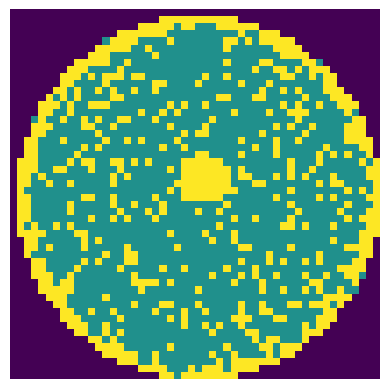

In [10]:
sample = df.sample(1).iloc[0]

print(f"Unique values in the waferMap: {np.unique(sample['waferMap'])}")

print(f"Label: {sample['label']}")
print(f"Failure type: {sample['failureType']}")
plt.imshow(sample["waferMap"])
plt.axis("off")
plt.show()